In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
vector.register_awkward()
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)
import pickle
import scipy as sp
import concurrent.futures
from tqdm.auto import tqdm
import os.path

Datasets : 
root://eos.grif.fr///eos/grif/cms/llr/store/user/tcuisset/boostedTaus/2018_MC/DYJetsToLL_M-50-amcatnloFXFX
nano_0.root to 47
xrdcp -r --parallel 4 root://eos.grif.fr///eos/grif/cms/llr/store/user/tcuisset/boostedTaus/2018_MC/DYJetsToLL_M-50-amcatnloFXFX /scratch/cuisset/2018_MC/

Dtaa : /eos/cms/store/group/phys_higgs/HLepRare/HTT_skim_v1/Run2_2018/EGamma_Run2018A to RunC
xrdcp -r --parallel 4 root://eoscms.cern.ch///eos/cms/store/group/phys_higgs/HLepRare/HTT_skim_v1/Run2_2018/EGamma_Run2018D /scratch/cuisset/HLepRare_skims/Run2_2018/

In [2]:
lumi = 59741
xs_dy = 6424
filter_name = ["HLT_Ele32_WPTight_Gsf", "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau*30_eta2p1_CrossL1", "TrigObj_*",
     "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", "Electron_charge",
    "Electron_mvaIso_WP90", "Electron_mvaNoIso_WP90", "Electron_mvaIso_WP80", "Electron_pfRelIso03_all", "Electron_dxy", "Electron_dz",
    "Tau_pt", "Tau_eta", "Tau_phi", "Tau_mass", "Tau_charge", "Tau_dz", "Tau_idDeepTau2017v2p1VS*", "Tau_rawDeepTau2017v2p1VSjet", "Tau_decayMode",
    "Muon_pt", "Muon_eta", "Muon_dz", "Muon_dxy", "Muon_pfRelIso04_all", "Muon_mediumId", "Muon_tightId",
    "Jet_pt", "Jet_eta", "Jet_phi", "Jet_jetId", "Jet_puId",
    "genWeight"]
# veto_muons = (np.abs(muon.eta)<=2.4) & (muon.pt >= 10) & (np.abs(muon.dz)<=0.2) & (np.abs(muon.dxy)<= 0.045) & (muon.pfRelIso04_all <= 0.3) & ((muon.mediumId)|(muon.tightId))

In [3]:
def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)

In [4]:
def zip_ar(ar):
    d = {b:ar[b] for b in ar.fields if b.startswith("HLT_") or b in ["genWeight", "run", "luminosityBlock"] or b.startswith("LHE")}
    for prefix in ["Electron", "Jet", "Muon", "Tau", "TrigObj"]:
        d |= {prefix:ak.zip({b[len(prefix)+1:]:ar[b] for b in ar.fields if b.startswith(prefix+"_")})}
    return ak.Array(d)    

In [5]:
def pass_cross_trigger(ar):
    pass_cross_HPS = ar.HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1 if "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1" in ar.fields else False
    pass_cross_noHPS = ar.HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau30_eta2p1_CrossL1 if "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau30_eta2p1_CrossL1" in ar.fields else False
    return pass_cross_HPS | pass_cross_noHPS
def pass_trigger_base(ar):
    return ar.HLT_Ele32_WPTight_Gsf | pass_cross_trigger(ar)

def good_electrons(ar):
    eles = ar.Electron
    abseta = np.abs(eles.eta)
    return (eles.pt > 25 ) & (abseta<2.5) & ((abseta<=1.44) | (abseta>=1.57)) & (eles.mvaIso_WP80) & (eles.dxy <= 0.045) & (eles.dz <= 0.2)
def sort_eles(good_eles):
    return good_eles[ak.argsort(good_eles.pfRelIso03_all*1e5 - good_eles.pt)] # sorting by Iso first then pt (lowest iso, highest pt)

def good_taus(ar):
    taus = ar.Tau
    # VsEle : 2 = VVLoose, 6 = Tight
    return (taus.idDeepTau2017v2p1VSmu >= 1) & (taus.idDeepTau2017v2p1VSe >= 6) & (taus.idDeepTau2017v2p1VSjet >= 5) & (taus.pt > 20 ) & (np.abs(taus.eta)<2.3) & (taus.dz<=0.2) & ((taus.decayMode == 0)|(taus.decayMode == 1)|(taus.decayMode == 10)|(taus.decayMode == 11))
def sort_taus(tau_cands):
    """ Sort taus to pick the best one """
    return tau_cands[ak.argsort(tau_cands.rawDeepTau2017v2p1VSjet*1e10 + tau_cands.pt, ascending=False)] # highest VsJet then highest pt 
def find_signal_tau(ar, signal_ele):
    """ NB : can return None in case taus fail deltaR """
    tau_cands = ar.Tau[good_taus(ar)]
    tau_cands = tau_cands[delta_r(signal_ele.eta, signal_ele.phi, tau_cands.eta, tau_cands.phi)>0.5]
    return ak.firsts(sort_taus(tau_cands))

def good_jets(ar):
    jets = ar.Jet
    return (jets.pt>20) & ((jets.pt > 50) | (jets.puId >= 1)) & (jets.jetId >= 6) & (jets.eta < 2.5)

def base_filter(ar):
    return pass_trigger_base(ar) & (ak.count_nonzero(good_electrons(ar), axis=-1)>=1) & (ak.count_nonzero(good_taus(ar), axis=-1)>=1) & (ak.count_nonzero(good_jets(ar), axis=-1)>=2)


In [6]:
# /grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/trigger/dy_0.root
# root://eos.grif.fr///eos/grif/cms/llr/store/user/tcuisset/boostedTaus/2018_MC/DYJetsToLL_M-50-amcatnloFXFX/nano_{i}.root
# ar_tot = uproot.concatenate([f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/trigger/dy_{i}.root:Events" for i in [1]],
#     filter_name=filter_name,
#     entry_stop=5000, how="zip")

In [7]:
base_out_path = "/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/trigger/etau_files_v2"
data_run_fileNb = list(zip(["A", "B", "C", "D"], [35, 16, 16, 76]))

In [8]:
# loading MC from pickle files
ars_dy_temp = []
sum_genWeight_temp = 0.
for fileNb in range(30):
    if fileNb == 12: continue
    out_name = f"dy_{fileNb}"
    with open(f"{base_out_path}/{out_name}.pkl", "rb") as f:
        pickle_res = pickle.load(f)
        sum_genWeight_temp += pickle_res["sum_genWeight"]
        ars_dy_temp.append(pickle_res["ar_base"])
ar_base_dy = ak.concatenate(ars_dy_temp)
sum_genWeight_dy = sum_genWeight_temp

In [9]:
# loading data from pickle files
ars_data_temp = []
for runPeriod, maxFileNb in data_run_fileNb:
    for fileNb in range(maxFileNb+1):
        out_name = f"data_Run2018{runPeriod}_{fileNb}"
        with open(f"{base_out_path}/{out_name}.pkl", "rb") as f:
            ar = pickle.load(f)["ar_base"]
            if "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1" not in ar.fields:
                ar = ak.with_field(ar, ak.full_like(ar.HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau30_eta2p1_CrossL1, False), "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1")
            elif "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau30_eta2p1_CrossL1" not in ar.fields:
                ar = ak.with_field(ar, ak.full_like(ar.HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1, False), "HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau30_eta2p1_CrossL1")
            ars_data_temp.append(ar)
ar_base_data = ak.concatenate(ars_data_temp)

In [24]:
def third_lepton_veto(ar, signal_ele):
    muon = ar.Muon
    veto_muons = (np.abs(muon.eta)<=2.4) & (muon.pt >= 10) & (np.abs(muon.dz)<=0.2) & (np.abs(muon.dxy)<= 0.045) & (muon.pfRelIso04_all <= 0.3) & ((muon.mediumId)|(muon.tightId))
    
    eles = ar.Electron
    abseta = np.abs(eles.eta)
    veto_eles =  (eles.pt >= 10 ) & (abseta<=2.5) & ((abseta<=1.44) | (abseta>=1.57)) & (((eles.pfRelIso03_all<0.3)&(eles.mvaNoIso_WP90)) | (eles.mvaIso_WP90)) & (eles.dxy <= 0.045) & (eles.dz <= 0.2)

    veto_eles = veto_eles & (~((eles.pt == signal_ele.pt) & (eles.eta == signal_ele.eta) & (eles.phi == signal_ele.phi))) # remove the signal electron from the list of veto electrons

    return ak.count_nonzero(veto_muons, axis=-1) + ak.count_nonzero(veto_eles, axis=-1) == 0

def opposite_sign(ar, signal_ele, signal_tau):
    return signal_ele.charge != signal_tau.charge

def two_jets(ar, signal_ele, signal_tau):
    jets = ar.Jet[good_jets(ar)]
    return ak.count_nonzero((delta_r(jets.eta, jets.phi, signal_ele.eta, signal_ele.phi)>0.5)&(delta_r(jets.eta, jets.phi, signal_tau.eta, signal_tau.phi)>0.5), axis=-1) >= 2

def ele_trigobjs(ar, signal_ele, type):
    if type == "single": # HLT_Ele32_WPTight_Gsf
        filterBits = (ar.TrigObj.filterBits & 2) >0
    elif type == "cross": # HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1
        filterBits = (ar.TrigObj.filterBits & 64) >0 #  https://twiki.cern.ch/twiki/bin/view/CMS/TauTrigger#Tau_Triggers_in_NanoAOD_2018
    else:
        raise ValueError()

    good_trigobjs = ar.TrigObj[(ar.TrigObj.id == 11) & filterBits]
    return ak.with_field(good_trigobjs, delta_r(good_trigobjs.eta, good_trigobjs.phi, signal_ele.eta, signal_ele.phi), "delta_r_signal_ele")

def tau_trigobjs(ar, signal_tau):
    good_trigobjs = ar.TrigObj[(ar.TrigObj.id == 15) & ( (ar.TrigObj.filterBits & 256) >0)]
    return ak.with_field(good_trigobjs, delta_r(good_trigobjs.eta, good_trigobjs.phi, signal_tau.eta, signal_tau.phi), "delta_r_signal_tau")

def check_singleEle_trigger(ar, signal_ele):
    good_trigobjs = ele_trigobjs(ar, signal_ele, "single")
    good_trigobjs = good_trigobjs[good_trigobjs.delta_r_signal_ele < 0.4]
    good_trigobj = ak.firsts(good_trigobjs[ak.argsort(good_trigobjs.delta_r_signal_ele)]) # pick closest in priority
    return ak.with_field(ak.with_field(ar, good_trigobj, "singleEle_trigObj"), (ar.HLT_Ele32_WPTight_Gsf) & (~ak.is_none(good_trigobj, axis=-1)) & (signal_ele.pt > 33), "passSingle")
    #return res & (ak.num(good_trigobj < 0.4, axis=-1)>=1) & (signal_ele.pt > 33)

def check_cross_trigger(ar, signal_ele, signal_tau):
    res = pass_cross_trigger(ar)
    good_trigobjs_ele = ele_trigobjs(ar, signal_ele, "cross")
    good_trigobjs_ele = good_trigobjs_ele[good_trigobjs_ele.delta_r_signal_ele < 0.4]
    good_trigobj_ele = ak.firsts(good_trigobjs_ele[ak.argsort(good_trigobjs_ele.delta_r_signal_ele)]) # pick closest in priority
    
    good_trigobjs_tau = tau_trigobjs(ar, signal_tau)
    good_trigobjs_tau = good_trigobjs_tau[good_trigobjs_tau.delta_r_signal_tau < 0.4]
    good_trigobj_tau = ak.firsts(good_trigobjs_tau[ak.argsort(good_trigobjs_tau.delta_r_signal_tau)]) # pick closest in priority

    res = ak.with_field(ar, good_trigobj_ele, "cross_ele_trigObj")
    res = ak.with_field(res, good_trigobj_tau, "cross_tau_trigObj")
    res = ak.with_field(res, (~ak.is_none(good_trigobj_ele, axis=-1)) & (~ak.is_none(good_trigobj_tau, axis=-1)) & (signal_ele.pt > 26) & (np.abs(signal_ele.eta)<2.1) & (signal_tau.pt > 35) & (np.abs(signal_tau.eta)<2.1) , "passCross")
    res = ak.with_field(res, (~ak.is_none(good_trigobj_tau, axis=-1)) & (signal_ele.pt > 26) & (np.abs(signal_ele.eta)<2.1) & (signal_tau.pt > 35) & (np.abs(signal_tau.eta)<2.1) , "passCrossNoEleMatch")
    return res

# def pass_trigger(ar, signal_ele, signal_tau ):
#     passSingle = check_singleEle_trigger(ar, signal_ele)
#     passCross = check_cross_trigger(ar, signal_ele, signal_tau)
#     return ak.with_field(ak.with_field(ar, passSingle, "passSingle"), passCross, "passCross")[passSingle|passCross], passSingle|passCross

In [33]:
def full_selections(ar_base):
    signal_ele_pre = sort_eles(ar_base.Electron[good_electrons(ar_base)])[:, 0]
    ar_base = ak.with_field(ar_base, signal_ele_pre, "signal_ele")
    ar_base = ak.with_field(ar_base, find_signal_tau(ar_base, signal_ele_pre), "signal_tau")
    # filter good ele+tau
    etau_good_evts = (~ak.is_none(ar_base.signal_ele)) & (~ak.is_none(ar_base.signal_tau))
    ar_offline_selections = ar_base[etau_good_evts]

    ar_final = check_cross_trigger(check_singleEle_trigger(ar_offline_selections, ar_offline_selections.signal_ele), ar_offline_selections.signal_ele, ar_offline_selections.signal_tau)
    trigger_filter = (ar_final.HLT_Ele32_WPTight_Gsf | pass_cross_trigger(ar_final)) # no trigger matching ! #ar_final.passCross | ar_final.passSingle
    ar_final = ar_final[trigger_filter]

    third_lepton_veto_filter = third_lepton_veto(ar_final, ar_final.signal_ele) & opposite_sign(ar_final, ar_final.signal_ele, ar_final.signal_tau) #& two_jets(ar_final, signal_ele, signal_tau)
    ar_final = ar_final[third_lepton_veto_filter]

    return ar_final

In [34]:
ar_dy = full_selections(ar_base_dy)
ar_data = full_selections(ar_base_data)

Text(0, 1, 'Events')

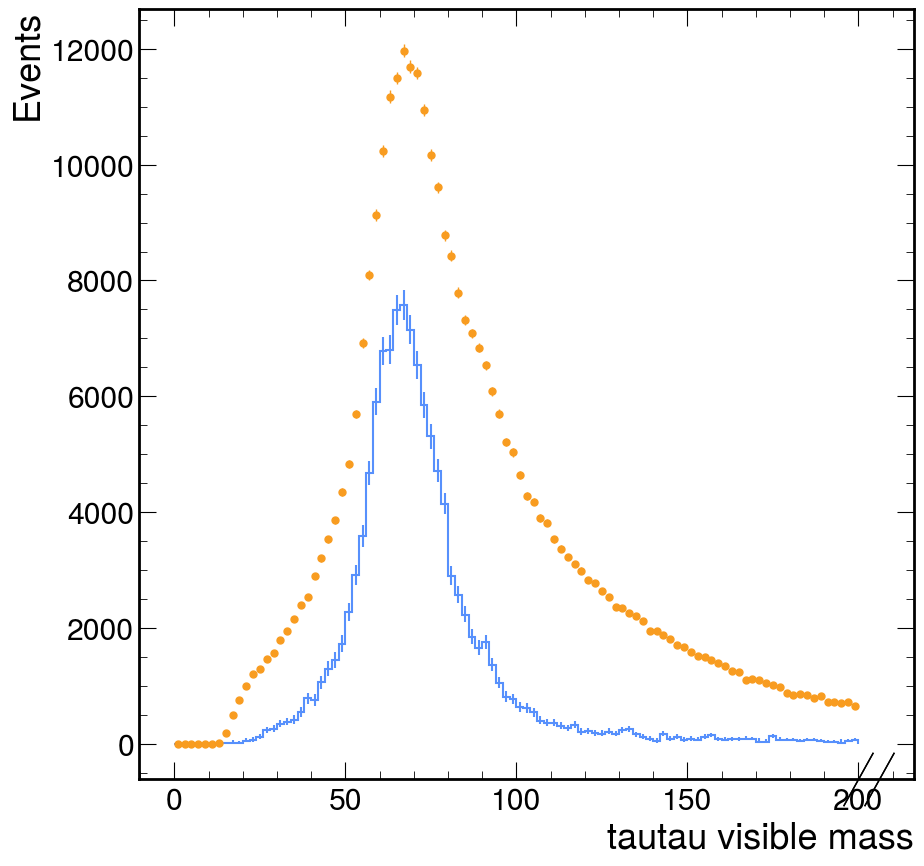

In [35]:
h_dy = hist.new.Regular(100, 0., 200., name="tautau visible mass").Weight().fill((ak.with_name(ar_dy.signal_ele[["pt", "eta", "phi", "mass"]], "Momentum4D") + ak.with_name(ar_dy.signal_tau[["pt", "eta", "phi", "mass"]], "Momentum4D")).mass, weight=lumi*xs_dy*ar_dy.genWeight/sum_genWeight_dy)
h_data = hist.new.Regular(100, 0., 200., name="tautau visible mass").Double().fill((ak.with_name(ar_data.signal_ele[["pt", "eta", "phi", "mass"]], "Momentum4D") + ak.with_name(ar_data.signal_tau[["pt", "eta", "phi", "mass"]], "Momentum4D")).mass)
hep.histplot(h_dy, label="DY") # *h_data.sum()*(1./h_dy.sum().value)
hep.histplot(h_data, histtype="errorbar")
plt.ylabel("Events")

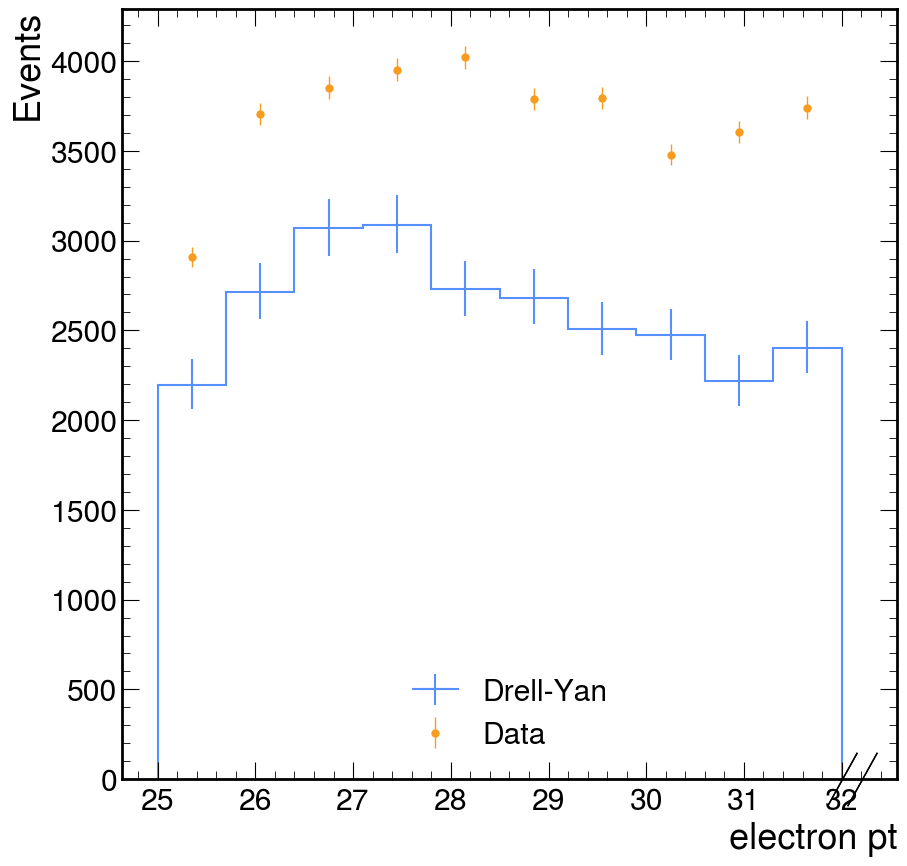

In [36]:

h_dy = hist.new.Regular(10, 25, 32., name="electron pt").Weight().fill(ar_dy.signal_ele.pt, weight=lumi*xs_dy*ar_dy.genWeight/sum_genWeight_dy)
h_data = hist.new.Regular(10, 25., 32., name="tautau visible mass").Double().fill(ar_data.signal_ele.pt)
hep.histplot(h_dy, label="Drell-Yan") # *h_data.sum()*(1./h_dy.sum().value)
hep.histplot(h_data, histtype="errorbar", label="Data")
plt.ylabel("Events")
plt.legend()

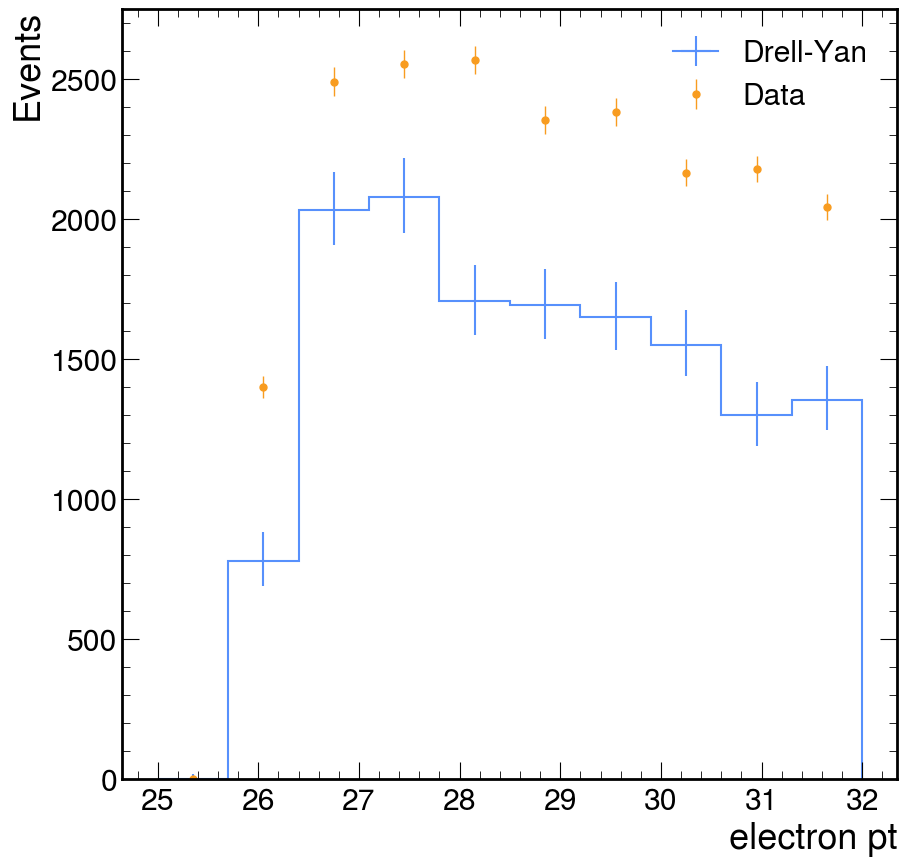

In [37]:
cross_dy = ar_dy[ar_dy.passCrossNoEleMatch & (ar_dy.signal_ele.pt<32)]
cross_data = ar_data[ar_data.passCrossNoEleMatch & (ar_data.signal_ele.pt<32)]
h_dy = hist.new.Regular(10, 25, 32., name="electron pt").Weight().fill(cross_dy.signal_ele.pt, weight=lumi*xs_dy*cross_dy.genWeight/sum_genWeight_dy)
h_data = hist.new.Regular(10, 25., 32., name="tautau visible mass").Double().fill(cross_data.signal_ele.pt)
hep.histplot(h_dy, label="Drell-Yan") # *h_data.sum()*(1./h_dy.sum().value)
hep.histplot(h_data, histtype="errorbar", label="Data")
plt.ylabel("Events")
plt.legend()

In [ ]:
cross_dy = ar_dy[ar_dy.passCross & (ar_dy.signal_ele.pt<32)]
cross_data = ar_data[ar_data.passCross & (ar_data.signal_ele.pt<32)]

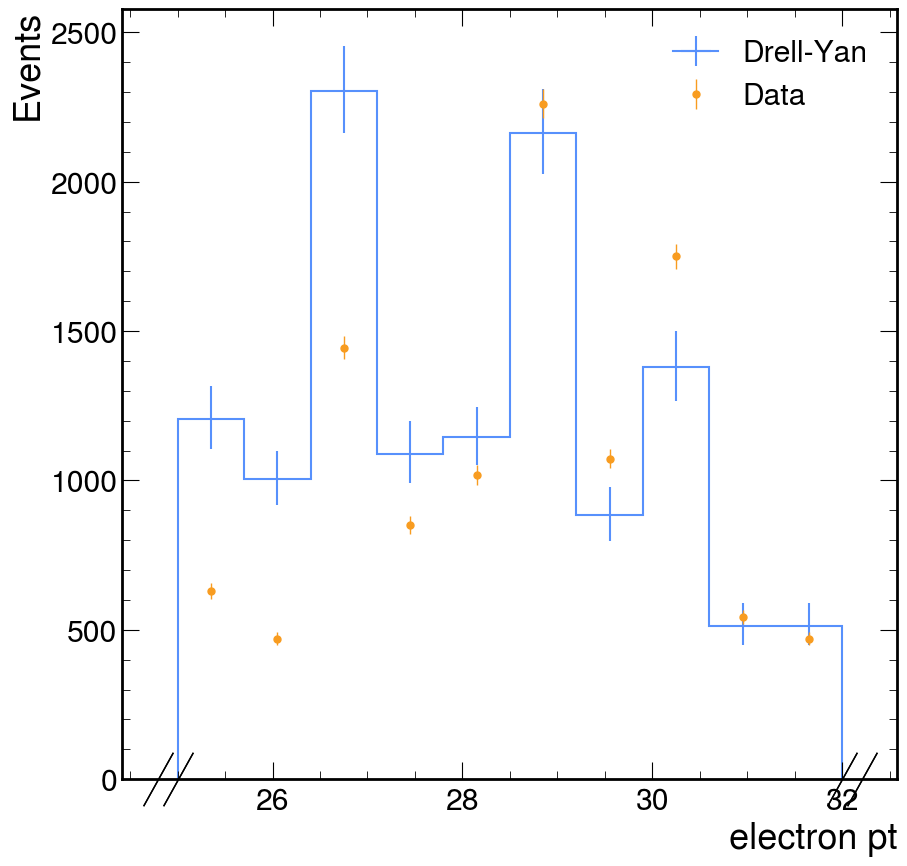

In [23]:
h_dy = hist.new.Regular(10, 25, 32., name="electron pt").Weight().fill(cross_dy.cross_ele_trigObj.l1pt, weight=lumi*xs_dy*cross_dy.genWeight/sum_genWeight_dy)
h_data = hist.new.Regular(10, 25., 32., name="tautau visible mass").Double().fill(cross_data.cross_ele_trigObj.l1pt)
hep.histplot(h_dy, label="Drell-Yan") # *h_data.sum()*(1./h_dy.sum().value)
hep.histplot(h_data, histtype="errorbar", label="Data")
plt.ylabel("Events")
plt.legend()

<Array [{l1charge: 0, id: 11, ...}, ..., {...}] type='5505 * ?{l1charge: in...'>